In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

%matplotlib inline

In [2]:
df = pd.read_csv("data/Fraud.csv")

df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [4]:
df.drop_duplicates(inplace=True)

In [5]:
df.nunique()

step                  743
type                    5
amount            5316900
nameOrig          6353307
oldbalanceOrg     1845844
newbalanceOrig    2682586
nameDest          2722362
oldbalanceDest    3614697
newbalanceDest    3555499
isFraud                 2
isFlaggedFraud          2
dtype: int64

In [6]:
df.shape

(6362620, 11)

In [7]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [8]:
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [9]:
pd.set_option("display.float_format", "{:.2f}".format)

In [10]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00
mean,243.40,179861.90,833883.10,855113.67,1100701.67,1224996.40,0.00,0.00
std,142.33,603858.23,2888242.67,2924048.50,3399180.11,3674128.94,0.04,0.00
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,156.00,13389.57,0.00,0.00,0.00,0.00,0.00,0.00
50%,239.00,74871.94,14208.00,0.00,132705.66,214661.44,0.00,0.00
75%,335.00,208721.48,107315.18,144258.41,943036.71,1111909.25,0.00,0.00
max,743.00,92445516.64,59585040.37,49585040.37,356015889.35,356179278.92,1.00,1.00


In [12]:
df.describe(include="object")

,type,nameOrig,nameDest
count,6362620,6362620,6362620
unique,5,6353307,2722362
top,CASH_OUT,C1530544995,C1286084959
freq,2237500,3,113


In [13]:
df["type"].value_counts()

type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64

In [14]:
sdf = df[["type", "isFraud", "isFlaggedFraud"]].copy()
sdf["isFraud"] = sdf["isFraud"].astype(object)
sdf["isFlaggedFraud"] = sdf["isFlaggedFraud"].astype(object)

sdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   type            object
 1   isFraud         object
 2   isFlaggedFraud  object
dtypes: object(3)
memory usage: 145.6+ MB


In [15]:
sdf.groupby("type").describe(include="all")

isFraud                     isFlaggedFraud                    
            count unique top     freq          count unique top     freq
type                                                                    
CASH_IN   1399284      1   0  1399284        1399284      1   0  1399284
CASH_OUT  2237500      2   0  2233384        2237500      1   0  2237500
DEBIT       41432      1   0    41432          41432      1   0    41432
PAYMENT   2151495      1   0  2151495        2151495      1   0  2151495
TRANSFER   532909      2   0   528812         532909      2   0   532893

In [16]:
from scipy.stats import chi2_contingency

contingency_nameOrig = pd.crosstab(df["nameOrig"], df["isFraud"])
contingency_nameDest = pd.crosstab(df["nameDest"], df["isFraud"])

In [17]:
statistic, p_value, dof, expected = chi2_contingency(contingency_nameOrig)

if p_value <= 0.05:
    print("Reject the null hypothesis: There is a significant association between nameOrig and isFraud.")
else:
    print("Fail to reject the null hypothesis: There is no significant association between nameOrig and isFraud.")

Fail to reject the null hypothesis: There is no significant association between nameOrig and isFraud.


In [18]:
statistic, p_value, dof, expected = chi2_contingency(contingency_nameDest)

if p_value <= 0.05:
    print("Reject the null hypothesis: There is a significant association between nameDest and isFraud.")
else:
    print("Fail to reject the null hypothesis: There is no significant association between nameDest and isFraud.")

Reject the null hypothesis: There is a significant association between nameDest and isFraud.


In [19]:
df.drop("nameOrig", axis=1, inplace=True)

In [20]:
nameDest_val_counts = df["nameDest"].value_counts()
frequent_vals = nameDest_val_counts[nameDest_val_counts > 1].index
df["dest_group"] = df["nameDest"].where(df["nameDest"].isin(frequent_vals), "other")
len(df["dest_group"].unique())

459659

In [21]:
df.drop("nameDest", axis=1, inplace=True)

In [22]:
sdf["dest_group"] = df["dest_group"].astype(object)
sdf.head()

,type,isFraud,isFlaggedFraud,dest_group
0,PAYMENT,0,0,other
1,PAYMENT,0,0,other
2,TRANSFER,1,0,C553264065
3,CASH_OUT,1,0,C38997010
4,PAYMENT,0,0,other


In [23]:
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,dest_group
0,1,PAYMENT,9839.64,170136.00,160296.36,0.00,0.00,0,0,other
1,1,PAYMENT,1864.28,21249.00,19384.72,0.00,0.00,0,0,other
2,1,TRANSFER,181.00,181.00,0.00,0.00,0.00,1,0,C553264065
3,1,CASH_OUT,181.00,181.00,0.00,21182.00,0.00,1,0,C38997010
4,1,PAYMENT,11668.14,41554.00,29885.86,0.00,0.00,0,0,other


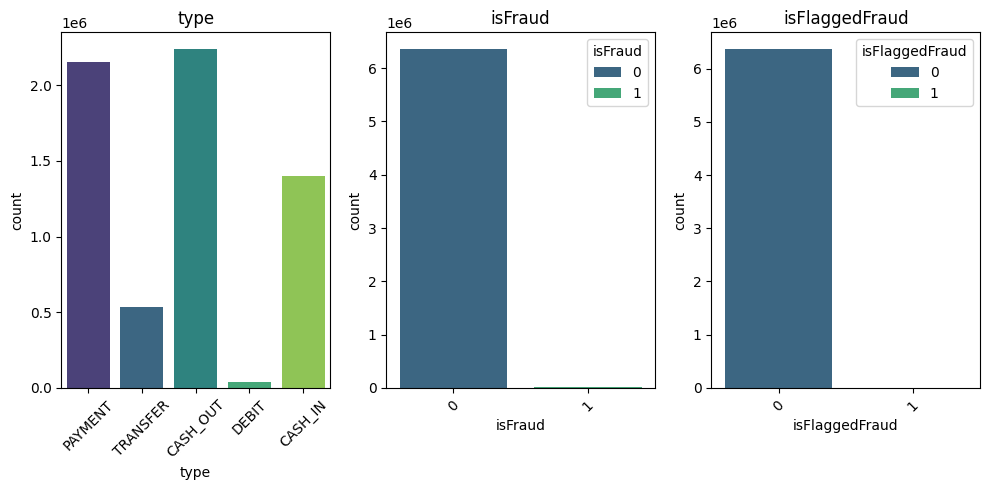

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

for i, col in enumerate(["type", "isFraud", "isFlaggedFraud"]):
    sns.countplot(x=col, hue=col, data=sdf, ax=axes[i], palette="viridis")
    axes[i].set_title(col)
    axes[i].tick_params(axis="x", labelrotation=45)

plt.tight_layout()

In [25]:
numerical_vals = df.select_dtypes(include=["int32", "int64", "float64"]).columns.tolist()

num_vals_stats = [val for val in numerical_vals if val not in {"isFraud", "isFlaggedFraud"}]

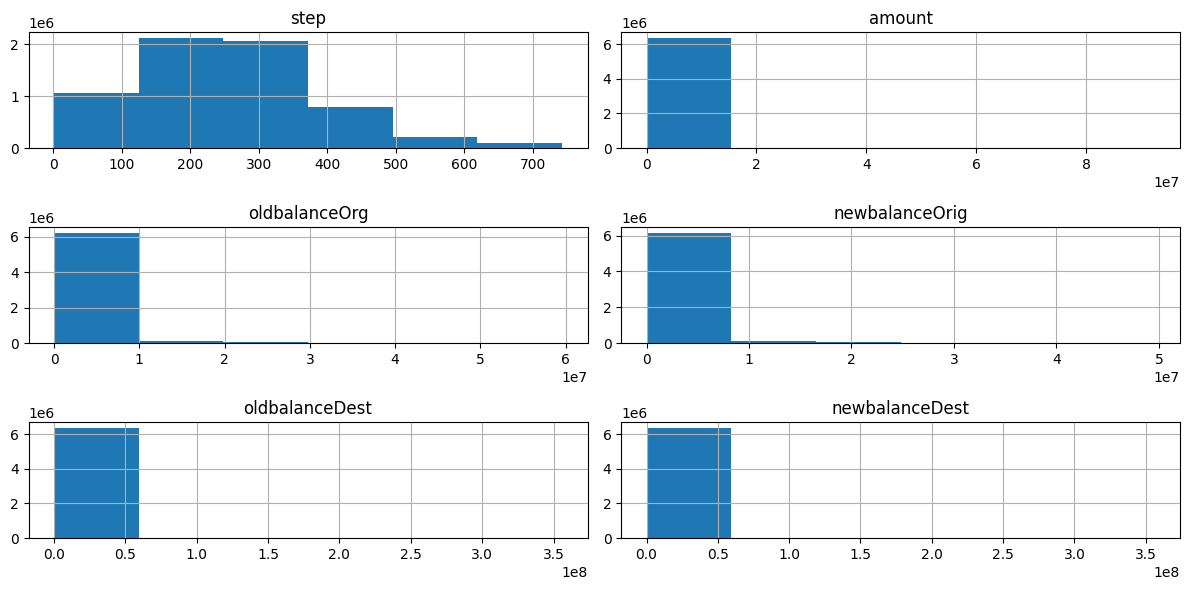

In [26]:
df[num_vals_stats].hist(figsize=(12, 6), layout=(3, 2), bins=6)
plt.tight_layout()

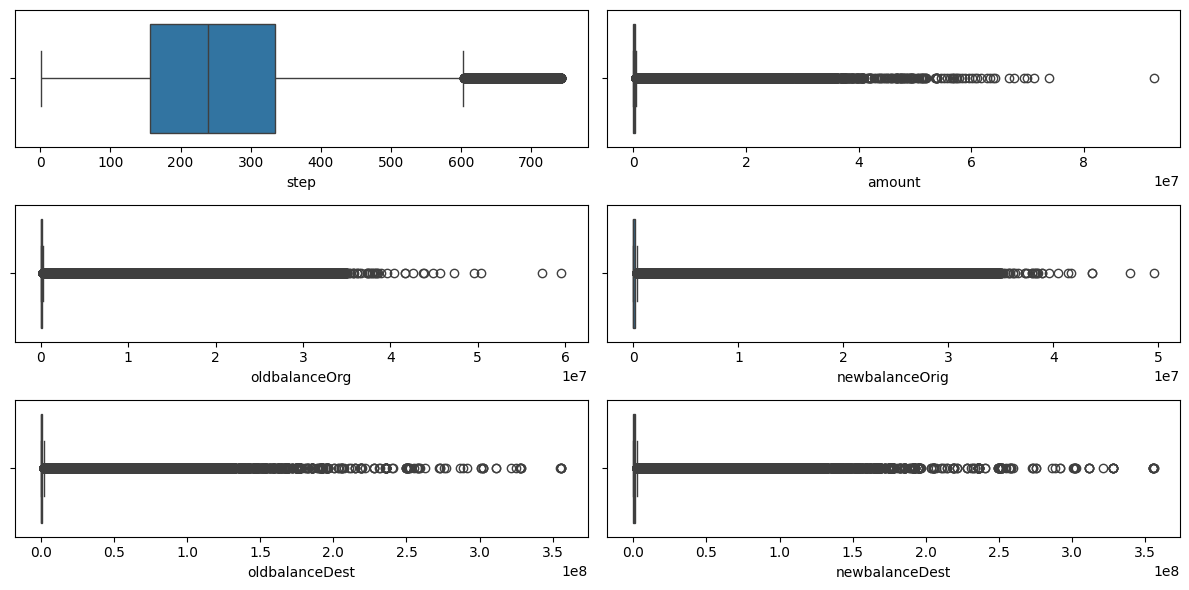

In [27]:
fig, axes = plt.subplots(3, 2, figsize=(12, 6))

for i, col in enumerate(num_vals_stats):
    sns.boxplot(data=df, x=col, ax=axes.flat[i])

plt.tight_layout()


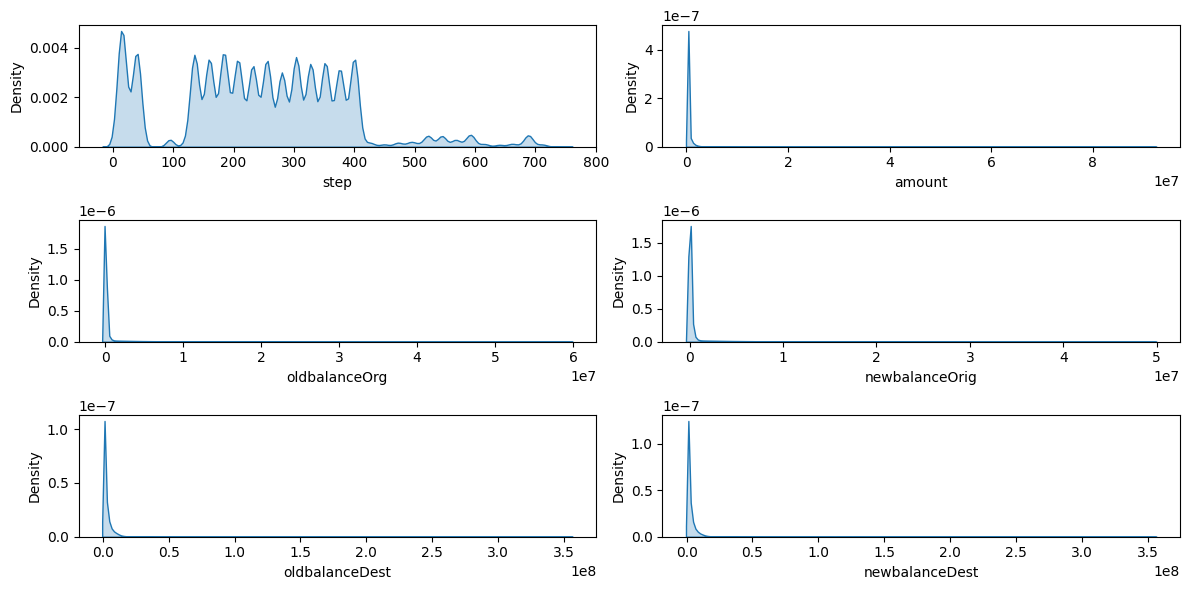

In [28]:
fig, axes = plt.subplots(3, 2, figsize=(12, 6))

for i, col in enumerate(num_vals_stats):
    sns.kdeplot(data=df, x=col, ax=axes.flat[i], fill=True)
    
plt.tight_layout()

Text(0.5, 1.0, 'Correlation Matrix of Numerical Features')

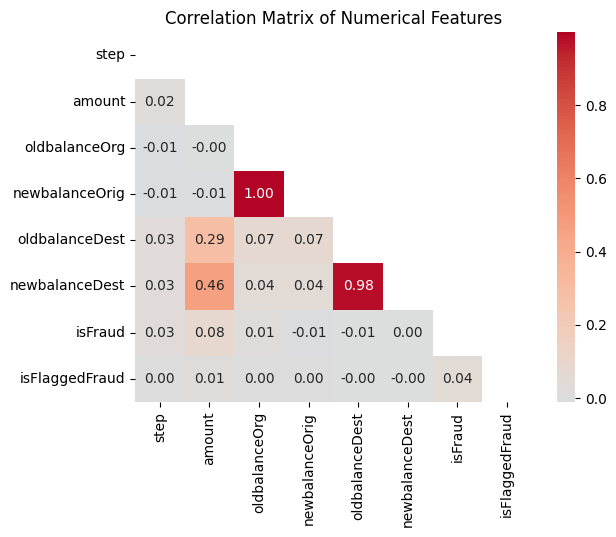

In [29]:
corr = df[numerical_vals].corr()
matrix = np.triu(corr)

sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0, mask=matrix)
plt.title("Correlation Matrix of Numerical Features")

In [30]:
sdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 4 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   type            object
 1   isFraud         object
 2   isFlaggedFraud  object
 3   dest_group      object
dtypes: object(4)
memory usage: 194.2+ MB


In [31]:
contingency_type = pd.crosstab(sdf["type"], sdf["isFraud"])

statistic, p_value, dof, expected = chi2_contingency(contingency_type)

if p_value <= 0.05:
    print("Reject the null hypothesis: There is a significant association between type and isFraud.")
else:
    print("Fail to reject the null hypothesis: There is no significant association between type and isFraud.")

Reject the null hypothesis: There is a significant association between type and isFraud.


In [32]:
types = pd.get_dummies(data=sdf["type"], prefix="type", dtype="int32")

types.head()

,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,0,0,0,1,0
1,0,0,0,1,0
2,0,0,0,0,1
3,0,1,0,0,0
4,0,0,0,1,0


In [33]:
sdf = pd.concat([sdf, types], axis=1)

sdf.drop("type", axis=1, inplace=True)
sdf.head()

,isFraud,isFlaggedFraud,dest_group,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,0,0,other,0,0,0,1,0
1,0,0,other,0,0,0,1,0
2,1,0,C553264065,0,0,0,0,1
3,1,0,C38997010,0,1,0,0,0
4,0,0,other,0,0,0,1,0


Text(0.5, 1.0, 'Correlation Matrix of Categorical Features')

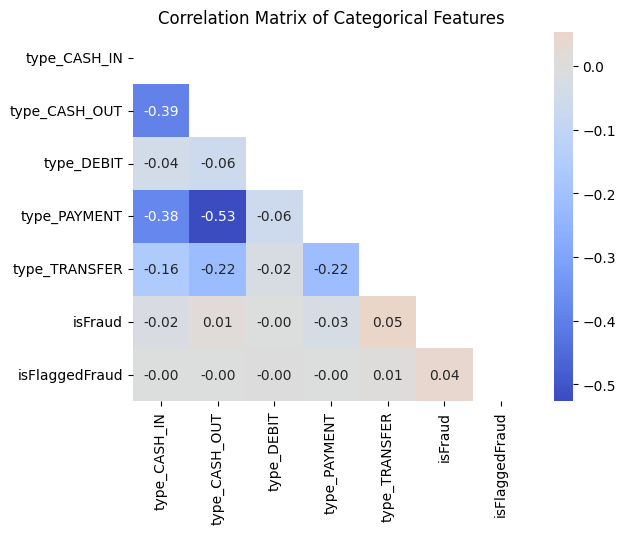

In [34]:
corr = sdf[types.columns.to_list() + ["isFraud", "isFlaggedFraud"]].corr()
matrix = np.triu(corr)

sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0, mask=matrix)
plt.title("Correlation Matrix of Categorical Features")

In [35]:
df.groupby(by=["isFraud", "type"])["amount"].count()

isFraud  type    
0        CASH_IN     1399284
         CASH_OUT    2233384
         DEBIT         41432
         PAYMENT     2151495
         TRANSFER     528812
1        CASH_OUT       4116
         TRANSFER       4097
Name: amount, dtype: int64

In [36]:
df.groupby("isFraud")["amount"].count()

isFraud
0    6354407
1       8213
Name: amount, dtype: int64

In [46]:
y = df["isFraud"]
X = df.drop(columns=["isFraud"])

In [47]:
X["type"] = X["type"].astype("category")
X["dest_group"] = X["dest_group"].astype("category")

In [48]:
y.value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [80]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, confusion_matrix, precision_recall_curve, roc_auc_score
from sklearn.model_selection import train_test_split

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [82]:
numerical_vars = X_train.select_dtypes(include="number").columns.tolist()

In [83]:
preprocess = ColumnTransformer(
    transformers=[
        ("numerical_vars", StandardScaler(), numerical_vars),
        ("categorical_vars_type", OneHotEncoder(handle_unknown="ignore"), ["type"]),
        ("categorical_vars_dest_group", TargetEncoder(), ["dest_group"]),
    ],
    remainder="passthrough",
)

In [84]:
preprocess

ColumnTransformer(remainder='passthrough',
                  transformers=[('numerical_vars', StandardScaler(),
                                 ['step', 'amount', 'oldbalanceOrg',
                                  'newbalanceOrig', 'oldbalanceDest',
                                  'newbalanceDest', 'isFlaggedFraud']),
                                ('categorical_vars_type',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['type']),
                                ('categorical_vars_dest_group', TargetEncoder(),
                                 ['dest_group'])])

In [85]:
X_train_transformed = preprocess.fit_transform(X_train, y_train)

In [104]:
feature_names = preprocess.get_feature_names_out()

In [86]:
scale_pos_weight = (y_train.value_counts()[0] / y_train.value_counts()[1])

model = xgb.XGBClassifier(
    objective="binary:logistic",
    scale_pos_weight=scale_pos_weight,
    eval_metric="aucpr",
    use_label_encoder=False,
    random_state=42,
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
)

In [87]:
model.fit(X_train_transformed, y_train)

/home/oxcompany/Projects/fraud_prediction/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [13:53:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, ...)

In [88]:
X_test_transformed = preprocess.transform(X_test)

In [89]:
y_probs = model.predict_proba(X_test_transformed)[:, 1]
y_pred = model.predict(X_test_transformed)

In [90]:
y_pred

array([0, 0, 0, ..., 0, 0, 0], shape=(1272524,))

In [91]:
recall_score(y_test.to_list(), y_pred)

0.9896530736457699

In [92]:
confusion_matrix(y_test.to_list(), y_pred)

array([[1268713,    2168],
       [     17,    1626]])

In [93]:
accuracy_score(y_test.to_list(), y_pred)

0.9982829400467104

In [94]:
f1_score(y_test.to_list(), y_pred)

0.5981239654221078

In [95]:
precision_score(y_test.to_list(), y_pred)

0.42857142857142855

In [96]:
roc_auc_score(y_test.to_list(), y_probs)

np.float64(0.9998216124301976)

In [97]:
print(f"""
the model true values
{y_test.value_counts()}

the model predicted values
0   {(y_pred == 0).sum()}
1   {(y_pred == 1).sum()}
""")


the model true values
isFraud
0    1270881
1       1643
Name: count, dtype: int64

the model predicted values
0   1268730
1   3794



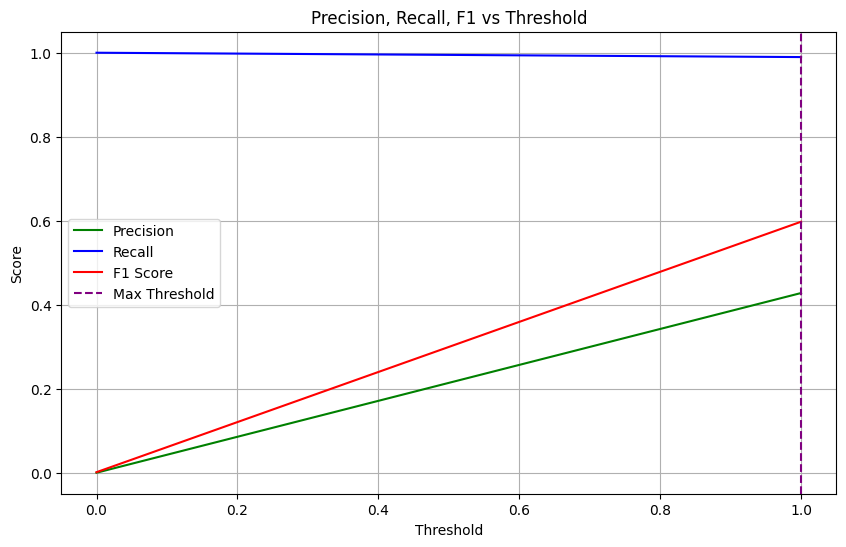

In [98]:
precisions, recalls, thresholds = precision_recall_curve(y_test.to_list(), y_pred)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions[:-1], label="Precision", color="green")
plt.plot(thresholds, recalls[:-1], label="Recall", color="blue")
plt.plot(thresholds, f1_scores[:-1], label="F1 Score", color="red")
plt.axvline(x=thresholds[1], color='purple', linestyle='--', label='Max Threshold')
plt.title("Precision, Recall, F1 vs Threshold")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.grid(True)

<Axes: ylabel='Count'>

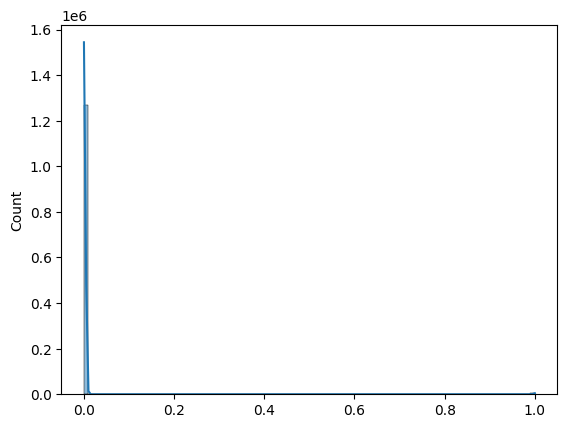

In [99]:
sns.histplot(y_pred, bins=100, kde=True)

In [101]:
precisions, recalls, thresholds = precision_recall_curve(y_test.to_list(), y_probs)

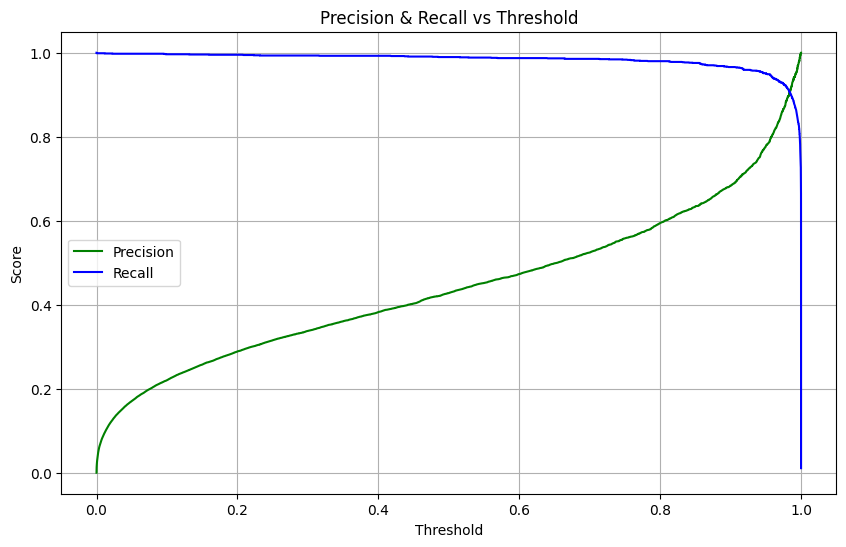

In [102]:
plt.figure(figsize=(10,6))
plt.plot(thresholds, precisions[:-1], label='Precision', color='green')
plt.plot(thresholds, recalls[:-1], label='Recall', color='blue')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision & Recall vs Threshold")
plt.legend()
plt.grid()
plt.show()

In [109]:
feature_names

array(['numerical_vars__step', 'numerical_vars__amount',
       'numerical_vars__oldbalanceOrg', 'numerical_vars__newbalanceOrig',
       'numerical_vars__oldbalanceDest', 'numerical_vars__newbalanceDest',
       'numerical_vars__isFlaggedFraud',
       'categorical_vars_type__type_CASH_IN',
       'categorical_vars_type__type_CASH_OUT',
       'categorical_vars_type__type_DEBIT',
       'categorical_vars_type__type_PAYMENT',
       'categorical_vars_type__type_TRANSFER',
       'categorical_vars_dest_group__dest_group'], dtype=object)

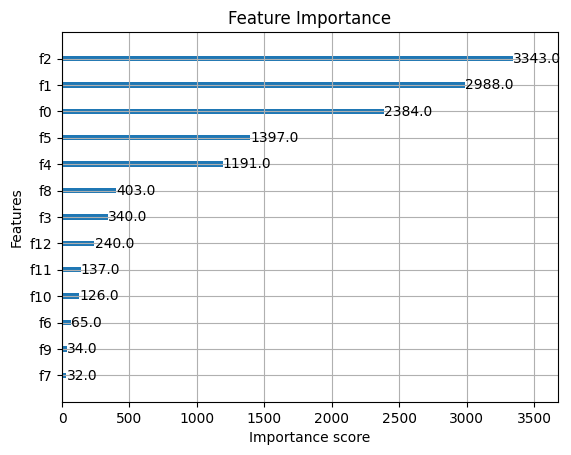

In [107]:
xgb.plot_importance(model, max_num_features=20)
plt.title("Feature Importance")
plt.show()